### <b>실전 프로젝트 - GAN을 이용한 얼굴 마스크 이미지 생성 </b>

* 마스크를 착용한 이미지와 마스크를 착용하지 않은 얼굴 이미지를 생성하는 <b>생성 모델</b>을 만드세요.
* 다음의 두 가지 대표적인 GAN 모델을 실습합니다.
    1. [Generative Adversarial Networks (NIPS 2014)](https://arxiv.org/abs/1406.2661)
    2. [Deep Convolutional Generative Adversarial Networks (ICLR 2016)](https://arxiv.org/abs/1511.06434)
* 또한 자신이 원하는 아키텍처의 GAN 모델을 직접 선택하여 학습하는 실습을 진행합니다.
* 본 프로젝트는 <b>최종적으로 높은 점수(score)를 얻는 것이 목표</b>입니다.
    * <b>Problem</b>이라고 명시된 부분의 소스코드만 작성합니다.
    * <b>알아보기</b>라고 명시된 부분은 단순히 읽고 실행하면 됩니다.
* 최종적으로 <b>팀 단위로 제출할 파일</b>은 다음과 같습니다.
    1. PPT 파일: 사용한 모델과 최종적인 FID 점수에 대한 설명을 포함하기
    2. Colab Notebook 파일: <b>[파일]</b> - <b>[다운로드]</b> - <b>[.ipynb 다운로드]</b>
    3. 최종 결과 이미지(마스크 착용 1,000개 및 마스크 미착용 1,000개)가 포함된 압축 파일
* 자세한 평가 기준은 <b>Problem 1</b>에서 확인하세요.

#### <b>(알아보기) 데이터셋 다운로드</b>

* 실습을 위해 [<b>Face Mask Classification</b> 데이터셋](https://github.com/ndb796/Face-Mask-Classification-20000-Dataset)을 불러옵니다.
* 데이터셋은 흑백(grayscale) 이미지로 구성됩니다.
* GPU 가속기를 이용하기 위해 <b>[런타임]</b> - <b>[런타임 유형 변경]</b> - <b>[GPU]</b>를 선택합니다.
* <b>학습 데이터셋</b>
    * 마스크 착용(with mask): 9,000장
    * 마스크 미착용(wihtout mask): 9,000장
* <b>테스트 데이터셋</b>
    * 마스크 착용(with mask): 1,000장
    * 마스크 미착용(wihtout mask): 1,000장


In [ ]:
!git clone https://github.com/ndb796/Face-Mask-Classification-20000-Dataset

fatal: destination path 'Face-Mask-Classification-20000-Dataset' already exists and is not an empty directory.


#### <b>(알아보기) 필요한 라이브러리 불러오기</b>

* 실습을 위한 PyTorch 라이브러리를 불러옵니다.

In [ ]:
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

#### <b>(알아보기) 학습 이미지 시각화</b>

* 학습할 이미지 중에서 원하는 이미지를 골라 시각화합니다.

이미지 크기: (224, 224)


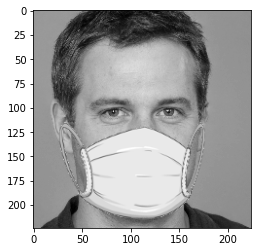

이미지 크기: (224, 224)


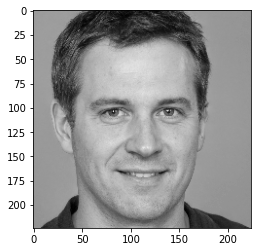

In [ ]:
# 마스크를 쓴 이미지 출력
image = Image.open('./Face-Mask-Classification-20000-Dataset/train/with_mask/with-mask-default-mask-seed0030.png')
print("이미지 크기:", image.size)

plt.imshow(image, cmap='gray')
plt.show()

# 마스크를 쓰지 않은 이미지 출력
image = Image.open('./Face-Mask-Classification-20000-Dataset/train/without_mask/seed0030.png')
print("이미지 크기:", image.size)

plt.imshow(image, cmap='gray')
plt.show()

#### <b>(알아보기) 데이터셋 불러오기</b>

* 학습할 이미지 크기: 1 X 64 X 64

In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalization
])

data_dir = './Face-Mask-Classification-20000-Dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
print('Train dataset size:', len(train_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 18000
Class names: ['with_mask', 'without_mask']


#### <b>(알아보기) 기본적인 GAN 실습 - 모델 정의</b>

* 논문 제목: [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) <b>(NIPS 2014)</b>
* 가장 기본적인 GAN 모델을 학습해보는 실습을 진행합니다.
    * 마스크 착용 여부를 선택하기 위해 <b>조건부(conditional) GAN</b>을 이용합니다.
    * <b>Reference</b>: [Conditional Generative Adversarial Nets (2014)](https://arxiv.org/abs/1411.1784)

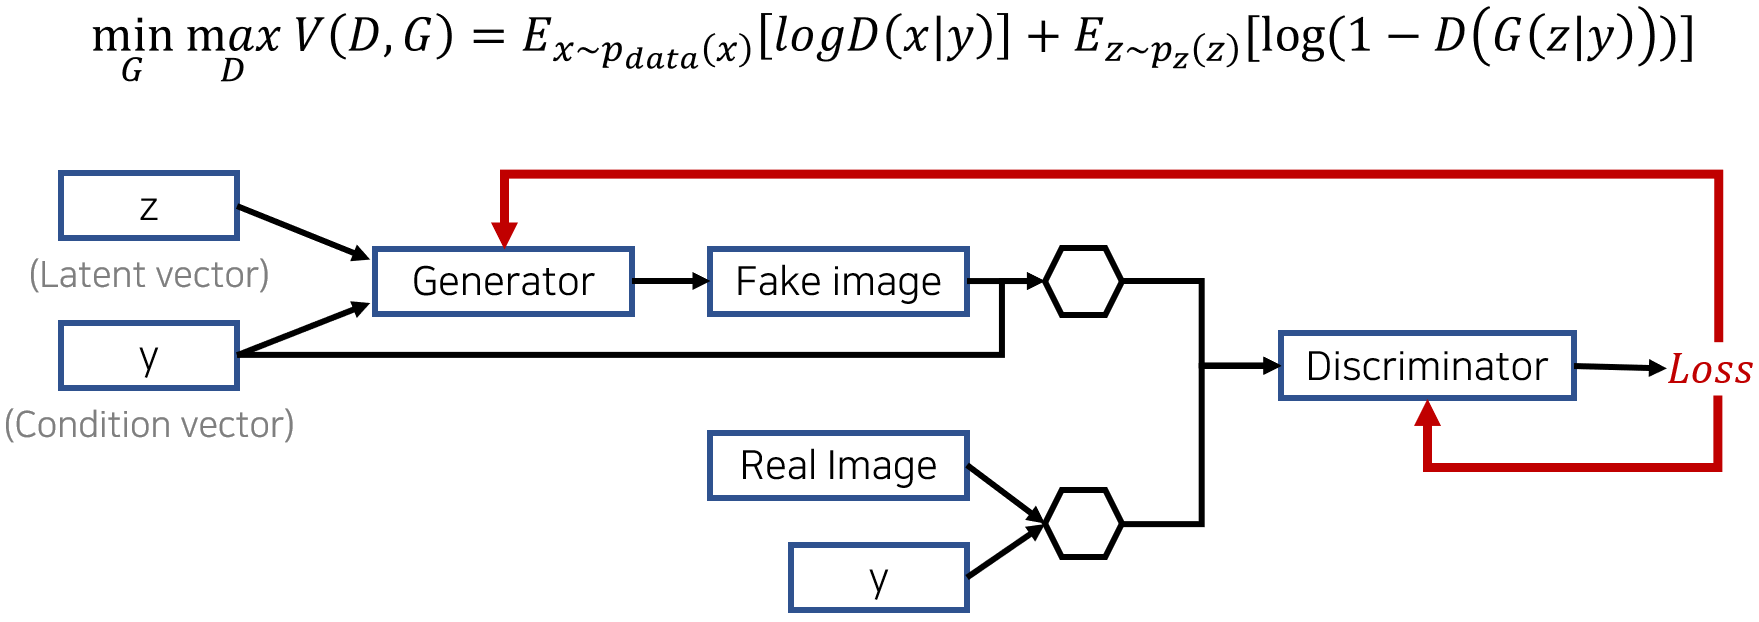

* 생성자(Generator) 및 판별자(Discriminator) 모델을 정의합니다.
    * 생성자 클래스: SimpleGenerator
    * 판별자 클래스: SimpleDiscriminator
* 본 소스코드는 원본 논문에서 제안한 아키텍처와 유사한 아키텍처를 이용합니다.
* <b>Reference</b>: [PyTorch GAN 예시 코드](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py)

In [ ]:
latent_dim = 100
n_classes = 2


# 생성자(Generator) 클래스 정의
class SimpleGenerator(nn.Module):
    def __init__(self):
      
        super(SimpleGenerator, self).__init__()

        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        self.label_embed = nn.Embedding(n_classes, n_classes)

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규화(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            *block(1024, 2048),
            nn.Linear(2048, 1 * 64 * 64),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # 노이즈(noise) 벡터와 레이블 임베딩을 순차적으로 연결하여 입력
        inputs = torch.cat((noise, self.label_embed(labels)), -1)
        img = self.model(inputs)
        img = img.view(img.size(0), 1, 64, 64)
        return img


# 판별자(Discriminator) 클래스 정의
class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super(SimpleDiscriminator, self).__init__()

        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        self.label_embed = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(1 * 64 * 64 + n_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img, labels):
        flattened = img.view(img.size(0), -1)
        # 이미지 벡터와 레이블 임베딩을 순차적으로 연결하여 입력
        inputs = torch.cat((flattened, self.label_embed(labels)), -1)
        output = self.model(inputs)

        return output

#### <b>(알아보기) 기본적인 GAN 실습 - 모델 학습 및 샘플링</b>

* 학습을 위해 생성자와 판별자 모델을 초기화합니다.
* 적절한 하이퍼 파라미터를 설정합니다.

In [ ]:
# 생성자(generator)와 판별자(discriminator) 초기화
simple_generator = SimpleGenerator()
simple_discriminator = SimpleDiscriminator()

simple_generator.cuda()
simple_discriminator.cuda()

# 손실 함수(loss function)
adversarial_loss = nn.MSELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(simple_generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(simple_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

* 모델을 학습하면서 주기적으로 샘플링하여 결과를 확인할 수 있습니다.

In [ ]:
!mkdir -p ./results/simple/

n_epochs = 20 # 학습의 횟수(epoch) 설정
sample_interval = 500 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()
# 
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()
        labels = labels.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        generated_labels = torch.randint(0, n_classes, (imgs.shape[0],)).cuda()

        # 이미지 생성
        generated_imgs = simple_generator(z, generated_labels)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(simple_discriminator(generated_imgs, generated_labels), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(simple_discriminator(real_imgs, labels), real)
        fake_loss = adversarial_loss(simple_discriminator(generated_imgs.detach(), generated_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            # 클래스당 8개의 이미지를 생성하여 2 X 8 격자 이미지에 출력
            z = torch.normal(mean=0, std=1, size=(n_classes * 8, latent_dim)).cuda()
            labels = torch.LongTensor([i for i in range(n_classes) for _ in range(8)]).cuda()
            generated_imgs = simple_generator(z, labels)
            save_image(generated_imgs, f"./results/simple/{done}.png", nrow=8, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

* 생성된 이미지 예시를 출력합니다.

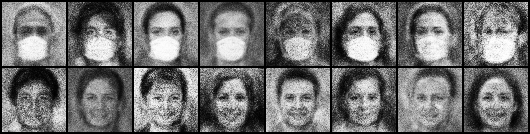

In [ ]:
from IPython.display import Image as Display

Display('./results/simple/28000.png')

* 다음의 코드를 이용하여 학습된 모델 파라미터를 저장할 수 있습니다.

In [ ]:
# 모델 파라미터 저장
!mkdir "./GAN_MODEL"
torch.save(simple_generator.state_dict(), "./GAN_MODEL/Simple_Generator_for_Face_Mask.pt")
torch.save(simple_discriminator.state_dict(), "./GAN_MODEL/Simple_Discriminator_for_Face_Mask.pt")
print("Model saved!")

Model saved!


* 학습된 모델 파라미터를 불러와 이미지 생성을 진행할 수 있습니다.

In [ ]:
# 생성자(generator) 초기화
simple_generator = SimpleGenerator()
simple_generator.cuda()
simple_generator.load_state_dict(torch.load("Simple_Generator_for_Face_Mask.pt"))
simple_generator.eval()

SimpleGenerator(
  (label_embed): Embedding(2, 2)
  (model): Sequential(
    (0): Linear(in_features=102, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=2048, bias=True)
    (12): BatchNorm1d(2048, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inpla

* 마스크를 착용한 얼굴을 생성합니다.

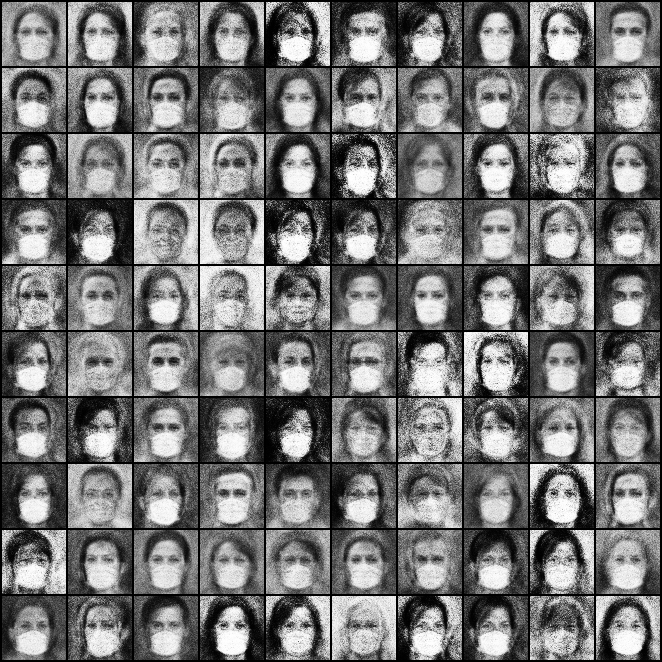

In [ ]:
from IPython.display import Image as Display

# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
generated_labels = torch.cuda.IntTensor(100).fill_(0)

# 이미지 생성
generated_imgs = simple_generator(z, generated_labels)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/simple/with_mask.png', nrow=10, normalize=True)

Display('./results/simple/with_mask.png')

* 마스크를 착용하지 않은 얼굴을 생성합니다.

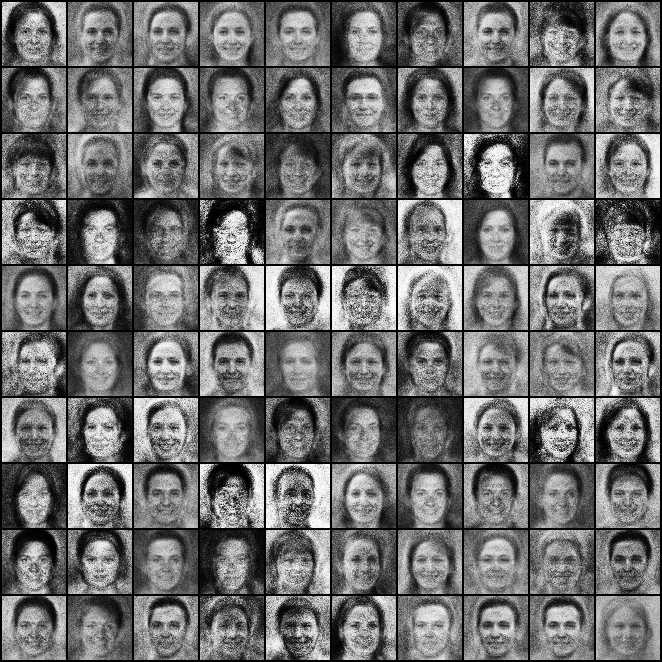

In [ ]:
from IPython.display import Image as Display

# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
generated_labels = torch.cuda.IntTensor(100).fill_(1)

# 이미지 생성
generated_imgs = simple_generator(z, generated_labels)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/simple/with_no_mask.png', nrow=10, normalize=True)

Display('./results/simple/with_no_mask.png')

#### <b>(알아보기) DCGAN 실습 - 모델 정의</b>

* 논문 제목: [Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) <b>(ICLR 2016)</b>
* Convoluational Layer를 활용하여 이미지 생성에 높은 성능을 보이는 DCGAN 모델을 학습해 봅시다.
    * 마스크 착용 여부를 선택하기 위해 <b>조건부(conditional) GAN</b>을 이용합니다.
    * <b>Reference</b>: [Conditional Generative Adversarial Nets (2014)](https://arxiv.org/abs/1411.1784)

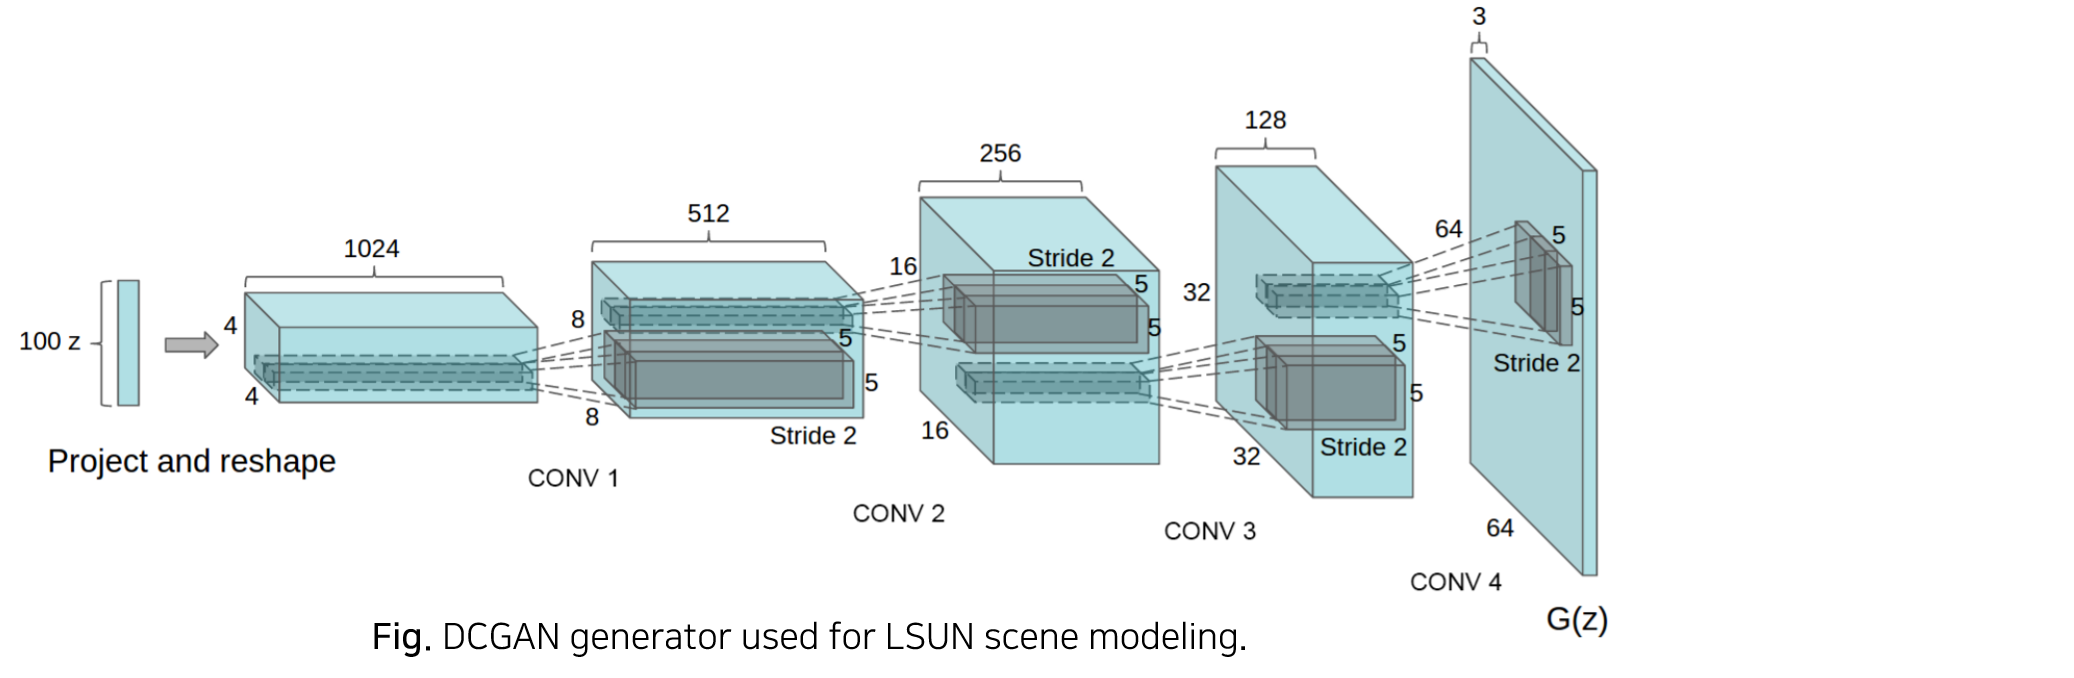

* 생성자(Generator) 및 판별자(Discriminator) 모델을 정의합니다.
    * 생성자 클래스: DCGANGenerator
    * 판별자 클래스: DCGANDiscriminator
* 본 소스코드는 원본 논문에서 제안한 아키텍처와 유사한 아키텍처를 이용합니다.
* <b>Reference</b>: [PyTorch DCGAN 예시 코드](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/dcgan/dcgan.py)

In [ ]:
latent_dim = 100
n_classes = 2


# 생성자(Generator) 클래스 정의
class DCGANGenerator(nn.Module):
    def __init__(self):
        super(DCGANGenerator, self).__init__()

        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        self.label_embed = nn.Embedding(n_classes, n_classes)

        self.init_size = 4 # 원본 크기보다 16배 작은 값으로 초기화
        self.layer1 = nn.Sequential(nn.Linear(latent_dim + n_classes, 512 * self.init_size * self.init_size)) # 초기 채널의 크기는 512 

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512), # 채널의 크기와 동일
            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 256으로
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 128로
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 64로
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 3으로
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        # 노이즈(noise) 벡터와 레이블 임베딩을 순차적으로 연결하여 입력
        inputs = torch.cat((noise, self.label_embed(labels)), -1)
        output = self.layer1(inputs)
        output = output.view(output.size(0), 512, self.init_size, self.init_size)
        output = self.conv_blocks(output)
        return output


# 판별자(Discriminator) 클래스 정의
class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super(DCGANDiscriminator, self).__init__()

        def make_block(in_channels, out_channels, bn=True):
            # 하나의 블록(block)을 반복할 때마다 너비와 높이는 2배씩 감소
            block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
            block.append(nn.LeakyReLU(0.2, inplace=True))
            block.append(nn.Dropout2d(0.25))
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        # 너비와 높이가 32배씩 감소
        self.conv_blocks = nn.Sequential(
            *make_block(2, 32, bn=False),
            *make_block(32, 64),
            *make_block(64, 128),
            *make_block(128, 256),
            *make_block(256, 512),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1),
            nn.Sigmoid()
        )

        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        self.label_embed = nn.Embedding(n_classes, 1 * 64 * 64)

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img, labels):
        # 이미지 벡터와 레이블 임베딩을 순차적으로 연결하여 입력
        embed = self.label_embed(labels).view((img.size(0), 1, 64, 64))
        inputs = torch.cat((img, embed), 1)
        output = self.conv_blocks(inputs)
        output = output.view(output.size(0), -1)
        output = self.classifier(output)
        return output

#### <b>(알아보기) DCGAN 실습 - 모델 학습 및 샘플링</b>

* 학습을 위해 생성자와 판별자 모델을 초기화합니다.
* 적절한 하이퍼 파라미터를 설정합니다.

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
dcgan_generator = DCGANGenerator()
dcgan_discriminator = DCGANDiscriminator()

dcgan_generator.cuda()
dcgan_discriminator.cuda()

# 가중치(weights) 초기화
dcgan_generator.apply(weights_init_normal)
dcgan_discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
adversarial_loss = nn.MSELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0001

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(dcgan_generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dcgan_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

* 모델을 학습하면서 주기적으로 샘플링하여 결과를 확인할 수 있습니다.

In [ ]:
!mkdir -p ./results/dcgan/

n_epochs = 100 # 학습의 횟수(epoch) 설정
sample_interval = 500 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()
        labels = labels.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        generated_labels = torch.randint(0, n_classes, (imgs.shape[0],)).cuda()

        # 이미지 생성
        generated_imgs = dcgan_generator(z, generated_labels)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(dcgan_discriminator(generated_imgs, generated_labels), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(dcgan_discriminator(real_imgs, labels), real)
        fake_loss = adversarial_loss(dcgan_discriminator(generated_imgs.detach(), generated_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            # 클래스당 8개의 이미지를 생성하여 2 X 8 격자 이미지에 출력
            z = torch.normal(mean=0, std=1, size=(n_classes * 8, latent_dim)).cuda()
            labels = torch.LongTensor([i for i in range(n_classes) for _ in range(8)]).cuda()
            generated_imgs = dcgan_generator(z, labels)
            save_image(generated_imgs, f"./results/dcgan/{done}.png", nrow=8, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

* 생성된 이미지 예시를 출력합니다.

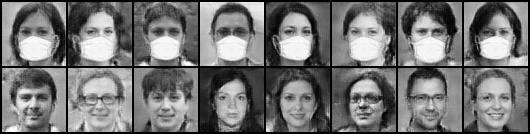

In [ ]:
from IPython.display import Image as Display

Display('./results/dcgan/28000.png')

* 다음의 코드를 이용하여 학습된 모델 파라미터를 저장할 수 있습니다.

In [ ]:
# 모델 파라미터 저장
torch.save(dcgan_generator.state_dict(), "DCGAN_Generator_for_Face_Mask.pt")
torch.save(dcgan_discriminator.state_dict(), "DCGAN_Discriminator_for_Face_Mask.pt")

torch.save(dcgan_generator.state_dict(), "./GAN_MODEL/DCGAN_Generator_for_Face_Mask.pt")
torch.save(dcgan_discriminator.state_dict(), "./GAN_MODEL/DCGAN_Discriminator_for_Face_Mask.pt")
print("Model saved!")

Model saved!


* 학습된 모델 파라미터를 불러와 이미지 생성을 진행할 수 있습니다.

In [ ]:
# 생성자(generator) 초기화
dcgan_generator = DCGANGenerator()
dcgan_generator.cuda()
dcgan_generator.load_state_dict(torch.load("DCGAN_Generator_for_Face_Mask.pt"))
dcgan_generator.eval()

DCGANGenerator(
  (label_embed): Embedding(2, 2)
  (layer1): Sequential(
    (0): Linear(in_features=102, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Upsample(scale_factor=2.0, mode=nearest)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_

* 마스크를 착용한 얼굴을 생성합니다.

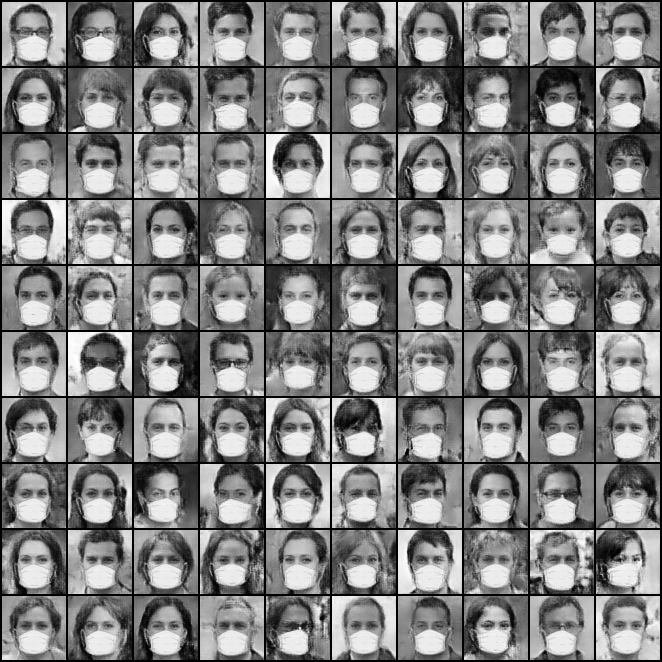

In [ ]:
from IPython.display import Image as Display

# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
generated_labels = torch.cuda.IntTensor(100).fill_(0)

# 이미지 생성
generated_imgs = dcgan_generator(z, generated_labels)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/dcgan/with_mask.png', nrow=10, normalize=True)

Display('./results/dcgan/with_mask.png')

* 마스크를 착용하지 않은 얼굴을 생성합니다.

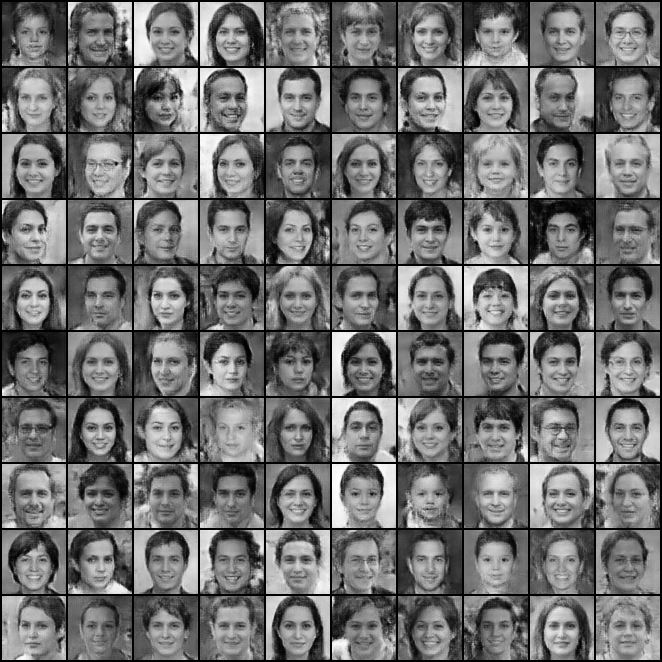

In [ ]:
from IPython.display import Image as Display

# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
generated_labels = torch.cuda.IntTensor(100).fill_(1)

# 이미지 생성
generated_imgs = dcgan_generator(z, generated_labels)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/dcgan/with_no_mask.png', nrow=10, normalize=True)

Display('./results/dcgan/with_no_mask.png')

#### <b>(알아보기) GAN 모델 평가하기 - FID Score</b>

* 논문 제목: [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/abs/1512.00567) <b>(CVPR 2016)</b>
* Fréchet Inception Distance(FID) 계산 방법
    * <b>생성된 이미지</b>들과 <b>실제 이미지</b>들을 ImageNet에 넣어 특징(feature)을 추출합니다.
    * 생성된 이미지 특징 분포 G와 실제 이미지 특징 분포 X를 가우시안 분포라고 가정합니다.
    * 두 분포가 얼마나 다른지 계산하기 위해 FID(X, G)를 계산합니다.
* [FID score for PyTorch](https://github.com/hukkelas/pytorch-frechet-inception-distance) 라이브러리를 이용해 간단히 계산할 수 있습니다.
    * 다음과 같이 소스코드를 다운로드할 수 있습니다.

In [ ]:
!git clone https://github.com/hukkelas/pytorch-frechet-inception-distance

fatal: destination path 'pytorch-frechet-inception-distance' already exists and is not an empty directory.


* <b>Simple GAN</b>: FID 점수를 계산하기 위해 마스크 착용 및 마스크 미착용 이미지를 1,000장씩 생성합니다.

In [ ]:
!mkdir -p ./results/simple/with_mask
!mkdir -p ./results/simple/without_mask

from IPython.display import Image as Display


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(0)
    # 이미지 생성
    generated_imgs = simple_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/simple/with_mask/{i * 100 + j}.png', normalize=True)


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(1)
    # 이미지 생성
    generated_imgs = simple_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/simple/without_mask/{i * 100 + j}.png', normalize=True)

* <b>DCGAN</b>: FID 점수를 계산하기 위해 마스크 착용 및 마스크 미착용 이미지를 1,000장씩 생성합니다.

In [ ]:
!mkdir -p ./results/dcgan/with_mask
!mkdir -p ./results/dcgan/without_mask

from IPython.display import Image as Display


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(0)
    # 이미지 생성
    generated_imgs = dcgan_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/dcgan/with_mask/{i * 100 + j}.png', normalize=True)


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(1)
    # 이미지 생성
    generated_imgs = dcgan_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/dcgan/without_mask/{i * 100 + j}.png', normalize=True)

* 다음과 같이 <b>FID를 계산</b>할 수 있습니다.
    * <b>FID 값이 낮을수록 우수한 모델</b>입니다.
* 메모리 초과 오류(CUDA error: out of memory)가 발생할 수 있습니다.
    * 메모리 초과가 발생할 때는 학습했던 GAN 네트워크를 잘 저장한 뒤에 <b>[런타임]</b> - <b>[런타임 다시 시작]</b>을 진행합니다.
* Simple GAN의 마스크 미착용 FID 점수: 260.75
* Simple GAN의 마스크 착용 FID 점수: 310.84
* DCGAN의 마스크 미착용 FID 점수: 170.21
* DCGAN의 마스크 착용 FID 점수: 131.82

In [ ]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/simple/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 32

Looking for images in ./results/simple/without_mask/*.png
Looking for images in ./results/simple/without_mask/*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask/*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask/*.jpg
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: 

In [ ]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/simple/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 32

Looking for images in ./results/simple/with_mask/*.png
Looking for images in ./results/simple/with_mask/*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask/*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask/*.jpg
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
310.83846332674597


In [ ]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/dcgan/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 32

Looking for images in ./results/dcgan/without_mask/*.png
Looking for images in ./results/dcgan/without_mask/*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask/*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask/*.jpg
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
170.20984505845

In [ ]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/dcgan/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 32

Looking for images in ./results/dcgan/with_mask/*.png
Looking for images in ./results/dcgan/with_mask/*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask/*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask/*.jpg
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
131.11851254033087


#### <b>Problem 1. 나만의 모델을 만들어 학습 및 

1.   DCGAN
2.   WGAN

평가하기</b>

* 나만의 GAN 모델을 이용해 <b>최대한 높은 FID 점수</b>를 받아보세요.
    * (Hint) 200 epochs 이상으로 학습해보기
    * (Hint) DCGAN의 아키텍처를 효율적으로 바꿔보기
    * (Hint) WGAN 등 [다른 아키텍처들을](https://github.com/eriklindernoren/PyTorch-GAN) 적용해보기
    * (Hint) 사전 학습된(pre-trained) GAN 모델 사용해보기
* 결과 이미지의 해상도는 1 X 64 X 64가 되어야 합니다.

##### i. DCGAN
  - epoch 200
  - loss function: Binary Cross Entropy (BCE)

  - 마스크 착용/미착용 이미지 1,000장씩 생성하여 계산한 최종 FID 점수(score)
    * 마스크 착용: 346.84
    * 마스크 미착용: 391.29

In [ ]:
# 생성자(Generator) 클래스 정의
latent_dim = 100
n_classes = 2

class CustomGenerator(nn.Module):
    def __init__(self, ngpu):
        super(CustomGenerator, self).__init__()
        self.ngpu = ngpu
        self.label_embed = nn.Embedding(n_classes, n_classes)
        self.init_size = 4
        self.layer1 = nn.Sequential(nn.Linear(latent_dim + n_classes, 512 * self.init_size * self.init_size))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512), # 채널의 크기와 동일
            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 256으로
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 128로
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 64로
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 3으로
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        inputs = torch.cat((noise, self.label_embed(labels)), -1)
        output = self.layer1(inputs)
        output = output.view(output.size(0), 512, self.init_size, self.init_size)
        output = self.conv_blocks(output)
        return output
        


# 판별자(Discriminator) 클래스 정의
class CustomDiscriminator(nn.Module):
    def __init__(self, ngpu):
        super(CustomDiscriminator, self).__init__()
        self.ngpu= ngpu
        def make_block(in_channels, out_channels, bn=True):
            # 하나의 블록(block)을 반복할 때마다 너비와 높이는 2배씩 감소
            block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
            block.append(nn.LeakyReLU(0.2, inplace=True))
            block.append(nn.Dropout2d(0.25))
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        # 너비와 높이가 32배씩 감소
        self.conv_blocks = nn.Sequential(
            *make_block(2, 32, bn=False),
            *make_block(32, 64),
            *make_block(64, 128),
            *make_block(128, 256),
            *make_block(256, 512),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1),
            nn.Sigmoid()
        )

        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        self.label_embed = nn.Embedding(n_classes, 1 * 64 * 64)

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img, labels):
        embed = self.label_embed(labels).view((img.size(0), 1, 64, 64))
        inputs = torch.cat((img, embed), 1)
        output = self.conv_blocks(inputs)
        output = output.view(output.size(0), -1)
        output = self.classifier(output)
        return output


In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
dcgan_generator = CustomGenerator(1)
dcgan_discriminator = CustomDiscriminator(1)

dcgan_generator.cuda()
dcgan_discriminator.cuda()

# 가중치(weights) 초기화
dcgan_generator.apply(weights_init_normal)
dcgan_discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
adversarial_loss = torch.nn.BCELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0001

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(dcgan_generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dcgan_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# 모델 학습하는 코드 작성하기
!mkdir -p ./results/customGAN/DCGAN/


n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 500 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

G_losses = []
D_losses = []

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()
        labels = labels.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        generated_labels = torch.randint(0, n_classes, (imgs.shape[0],)).cuda()

        # 이미지 생성
        generated_imgs = dcgan_generator(z, generated_labels)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(dcgan_discriminator(generated_imgs, generated_labels), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(dcgan_discriminator(real_imgs, labels), real)
        fake_loss = adversarial_loss(dcgan_discriminator(generated_imgs.detach(), generated_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            # 클래스당 8개의 이미지를 생성하여 2 X 8 격자 이미지에 출력
            z = torch.normal(mean=0, std=1, size=(n_classes * 8, latent_dim)).cuda()
            labels = torch.LongTensor([i for i in range(n_classes) for _ in range(8)]).cuda()
            generated_imgs = dcgan_generator(z, labels)
            save_image(generated_imgs, f"./results/customGAN/DCGAN/{done}.png", nrow=8, normalize=True)
        
        if i % 5 == 0:
          G_losses.append(g_loss.item())
          D_losses.append(d_loss.item())
    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")



[Epoch 0/200] [D loss: 0.255544] [G loss: 0.260506] [Elapsed time: 24.50s]
[Epoch 1/200] [D loss: 0.248865] [G loss: 0.257401] [Elapsed time: 49.72s]
[Epoch 2/200] [D loss: 0.256995] [G loss: 0.261580] [Elapsed time: 74.41s]
[Epoch 3/200] [D loss: 0.247008] [G loss: 0.271820] [Elapsed time: 99.11s]
[Epoch 4/200] [D loss: 0.246708] [G loss: 0.213214] [Elapsed time: 123.93s]
[Epoch 5/200] [D loss: 0.248996] [G loss: 0.249926] [Elapsed time: 149.14s]
[Epoch 6/200] [D loss: 0.262616] [G loss: 0.220487] [Elapsed time: 174.06s]
[Epoch 7/200] [D loss: 0.257240] [G loss: 0.239449] [Elapsed time: 199.00s]
[Epoch 8/200] [D loss: 0.237670] [G loss: 0.252589] [Elapsed time: 224.05s]
[Epoch 9/200] [D loss: 0.231536] [G loss: 0.272993] [Elapsed time: 249.93s]
[Epoch 10/200] [D loss: 0.244234] [G loss: 0.257148] [Elapsed time: 275.06s]
[Epoch 11/200] [D loss: 0.245747] [G loss: 0.272364] [Elapsed time: 300.25s]
[Epoch 12/200] [D loss: 0.254705] [G loss: 0.216371] [Elapsed time: 325.45s]
[Epoch 13/200

In [ ]:
# 모델 파라미터 저장
from google.colab import files
torch.save(dcgan_generator.state_dict(), "DCGAN_Generator_for_Face_Mask.pt")
files.download('./DCGAN_Generator_for_Face_Mask.pt')
torch.save(dcgan_discriminator.state_dict(), "DCGAN_Discriminator_for_Face_Mask.pt")
files.download('./DCGAN_Discriminator_for_Face_Mask.pt')


torch.save(dcgan_generator.state_dict(), "DCGAN_Generator_for_Face_Mask.pt")
files.download('./DCGAN_Generator_for_Face_Mask.pt')
torch.save(dcgan_discriminator.state_dict(), "DCGAN_Discriminator_for_Face_Mask.pt")
files.download('./DCGAN_Discriminator_for_Face_Mask.pt')

print("Model saved!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model saved!


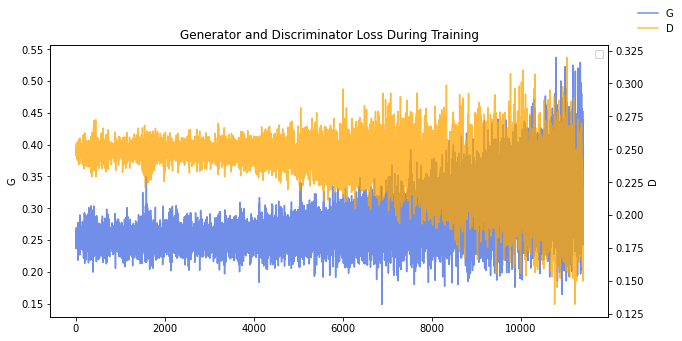

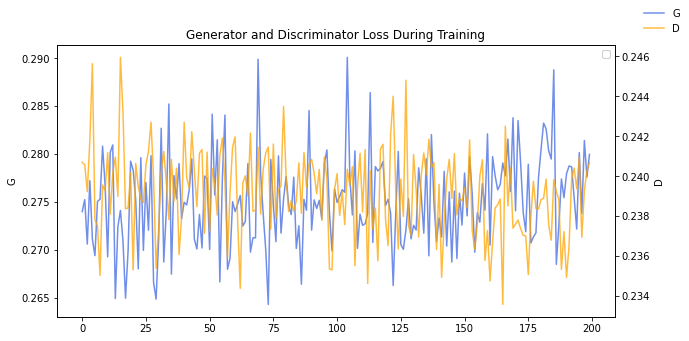

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
df = pd.DataFrame({'G': G_losses[1:], 'D': D_losses[1:]})
ax1 = sns.lineplot(data=df, x=df.index, y='G', label='G', color='royalblue', alpha=.75)
ax2 = ax1.twinx()
sns.lineplot(data=df, x=df.index, y='D', label='D', color='orange', alpha=.75, ax=ax2)
for ax in [ax1, ax2]:
#     ax.set_ylim(bottom=0.)
    ax.legend([])
ax1.figure.legend(frameon= False)
plt.savefig("./Loss_during_Train1.png")
plt.show()


plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
df = pd.DataFrame({
    'G': np.mean(np.array(G_losses).reshape(len(G_losses) // n_epochs, -1), axis=0),
    'D': np.mean(np.array(D_losses).reshape(len(D_losses) // n_epochs, -1), axis=0)
})
ax1 = sns.lineplot(data=df, x=df.index, y='G', label='G', color='royalblue', alpha=.75)
ax2 = ax1.twinx()
sns.lineplot(data=df, x=df.index, y='D', label='D', color='orange', alpha=.75, ax=ax2)
for ax in [ax1, ax2]:
#     ax.set_ylim(bottom=0.)
    ax.legend([])
ax1.figure.legend(frameon=False)
plt.savefig("./Loss_during_Train2.png")
plt.show()

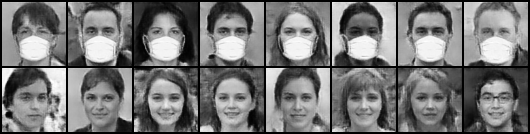

In [ ]:
from IPython.display import Image as Display

Display('./results/customGAN/DCGAN/28000.png')

In [ ]:
# 생성자(generator) 초기화
dcgan_generator = CustomGenerator(1)
dcgan_generator.cuda()
dcgan_generator.load_state_dict(torch.load("./DCGAN_Generator_for_Face_Mask.pt"))
dcgan_generator.eval()


CustomGenerator(
  (label_embed): Embedding(2, 2)
  (layer1): Sequential(
    (0): Linear(in_features=102, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Upsample(scale_factor=2.0, mode=nearest)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running

In [ ]:
!mkdir -p ./results/customGAN/DCGAN/with_mask
!mkdir -p ./results/customGAN/DCGAN/without_mask

In [ ]:

from IPython.display import Image as Display


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(0)
    # 이미지 생성
    generated_imgs = dcgan_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/customGAN/DCGAN/with_mask/{i * 100 + j}.png', normalize=True)


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(1)
    # 이미지 생성
    generated_imgs = dcgan_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/customGAN/DCGAN/without_mask/{i * 100 + j}.png', normalize=True)

In [ ]:
# 평가 수행 : face-without-mask
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/customGAN/DCGAN/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 32

Looking for images in ./results/customGAN/DCGAN/without_mask/*.png
Looking for images in ./results/customGAN/DCGAN/without_mask/*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask/*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask/*.jpg
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(

In [ ]:
# 평가 수행 : face-with-mask
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/customGAN/DCGAN/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 32

Looking for images in ./results/customGAN/DCGAN/with_mask/*.png
Looking for images in ./results/customGAN/DCGAN/with_mask/*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask/*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask/*.jpg
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
343.376

In [ ]:
# .//content/results/customGAN/DCGAN/ 폴더의 모든 파일을 results_customDCGAN.zip라는 이름으로 압축
!zip ./results_customDCGAN.zip -r ./results/customGAN/DCGAN/*
files.download('./results_customDCGAN.zip')

updating: results/customGAN/DCGAN/with_mask/ (stored 0%)
updating: results/customGAN/DCGAN/with_mask/970.png (deflated 2%)
updating: results/customGAN/DCGAN/with_mask/701.png (deflated 1%)
updating: results/customGAN/DCGAN/with_mask/206.png (deflated 0%)
updating: results/customGAN/DCGAN/with_mask/119.png (deflated 1%)
updating: results/customGAN/DCGAN/with_mask/803.png (deflated 1%)
updating: results/customGAN/DCGAN/with_mask/85.png (deflated 1%)
updating: results/customGAN/DCGAN/with_mask/888.png (deflated 1%)
updating: results/customGAN/DCGAN/with_mask/789.png (deflated 1%)
updating: results/customGAN/DCGAN/with_mask/419.png (deflated 1%)
updating: results/customGAN/DCGAN/with_mask/861.png (deflated 1%)
updating: results/customGAN/DCGAN/with_mask/883.png (deflated 0%)
updating: results/customGAN/DCGAN/with_mask/59.png (deflated 1%)
updating: results/customGAN/DCGAN/with_mask/293.png (deflated 1%)
updating: results/customGAN/DCGAN/with_mask/123.png (deflated 1%)
updating: results/cus

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### ii. WGAN
**DCGAN의 한계**
- 판별자를 속이는 이미지를 만들도록 학습했기 때문에, 잘 속이는 일부 샘플(mode)을 발견하면 그것만 계속 만들어낸다.(mode collapse) 
    - BCE(binary cross-entropy) 사용할 때 생기는 문제 중 하나. 
    - 판별자를 잘 속이는 샘플만 생성 ( == 생성자가 Local minimum에 빠진 상태!)
    
    \* mode: 분포 높은 부분! 
    
    e.g., Mnist: Mnist의 경우 class 10개 이기 때문에 mode 10 개 있는 multiple-modes dist. )
- 잠재 공간의 모든 포인트가 일부 샘플로 모이면, 손실 함수의 미분값이 0에 가까운 값으로 무너지게 된다 (gradient vanishing)
    - 생성자는 BCE를 (실제와 생성의 확률 분포의 차이)를 줄이는 방향, 판별자는 BCE를 최대화 하는 방향으로 학습 진행 ==> minimaxgame
    - 생성자는 판별자보다 학습이 어려움!
        - 판별자 : real (1) / fake (0) -> 이진적으로 판별
        - 생성자: 이미지를 생성..!
    - 학습 초기에는 생성자나 판별자나 성능이 좋지 않기 때문에 생성자에게 좋은 피드백 줄 수 있음
    - 판별자의 학습이 진행 될 수록, 생성된 것과 실제를 잘 구별하게되어 1의 분포에 가까워지며, 생성자는 반대로 0에 가까워짐. 
	  ++ 판별자는 학습이 잘 될수록 0에 근접한 gradient 반환 —> 생성자에게 좋지 않은 피드백 —> 학습종료..

**result (FID)**
- Try 1
  - epoch: 100 / Optimizer: Adam
    - face with mask: Inf.
    - facw without mask: 442.33
    - loss log

    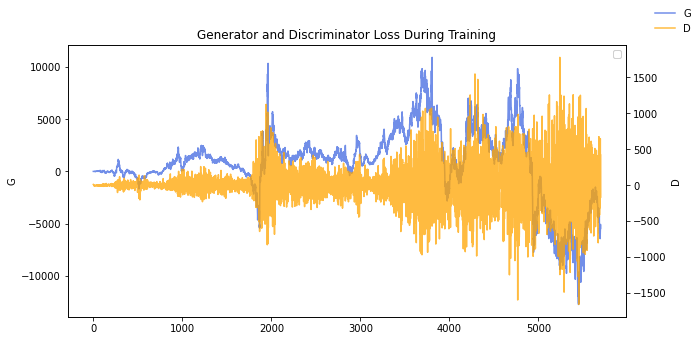

- Try 2
  - epoch: 300 / Optimizer: adam
  - face with mask: Index err
  - face without mask: 185.17
    - 레이블 누락으로 마스크 유무를 구분하지 못하였지만 WGAN-GP convolution layer 버전보다 나은 결과를 얻음..
  - fully connected
  - label missing..



In [1]:
import os
import easydict
import time
from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import pandas as pd
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
from torch import autograd


cuda = True if torch.cuda.is_available() else False

In [2]:
!git clone https://github.com/ndb796/Face-Mask-Classification-20000-Dataset

Cloning into 'Face-Mask-Classification-20000-Dataset'...
remote: Enumerating objects: 20017, done.
remote: Total 20017 (delta 0), reused 0 (delta 0), pack-reused 20017
Receiving objects: 100% (20017/20017), 600.78 MiB | 41.42 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (20001/20001), done.


In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalization
])

data_dir = './Face-Mask-Classification-20000-Dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
print('Train dataset size:', len(train_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 18000
Class names: ['with_mask', 'without_mask']


In [3]:
!git clone https://github.com/hukkelas/pytorch-frechet-inception-distance

Cloning into 'pytorch-frechet-inception-distance'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (22/22), done.


In [4]:
# 생성자(Generator) 클래스 정의
latent_dim = 100
n_classes = 2

class WGANGPGenerator(nn.Module):
    def __init__(self):
        super(WGANGPGenerator, self).__init__()
        # self.ngpu = ngpu
      
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, 1*64*64),
            nn.Tanh()
        )
    def forward(self, noise):
        output = self.model(noise)
        output = output.view(noise.size(0),1,64,64)

        return output
# 판별자(Discriminator) 클래스 정의
class WGANGPDiscriminator(nn.Module):
    def __init__(self):
        super(WGANGPDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1*64*64, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )
        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        # self.label_embed = nn.Embedding(n_classes, 1 * 64* 64)
    
    # 이미지에 대한 판별 결과
    def forward(self, img):
        img_flat= img.view(img.shape[0], -1)
        output= self.model(img_flat)
        return output


In [5]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))

    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [6]:
# 하이퍼 파라미터 설정 
lr = 0.0002
lambda_gp = 10
n_epochs = 300 # 학습의 횟수(epoch) 설정
sample_interval = 500 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

# iter 관리 
args = easydict.EasyDict({
        "mode" : 'train',
        "model_file" : "./Face-Mask-Classification-20000-Dataset",
        "n_critic" : 5,
        "sample_interval" : 500,
        "latent_dim": 100
      })


In [11]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [12]:
# 생성자(generator)와 판별자(discriminator) 초기화
wganGP_generator = WGANGPGenerator()
wganGP_discriminator = WGANGPDiscriminator()

wganGP_generator.cuda()
wganGP_discriminator.cuda()

# 가중치(weights) 초기화
wganGP_generator.apply(weights_init_normal)
wganGP_discriminator.apply(weights_init_normal)

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(wganGP_generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(wganGP_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# 모델 학습하는 코드 작성하기
!mkdir -p ./results/customGAN/WGAN-GP/

G_losses = []
D_losses = []

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()
        # labels = labels.cuda()

        # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
        # z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], args.latent_dim))))
        # fake_labels = torch.randint(0, n_classes, (imgs.shape[0],)).cuda()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()
        
        # fake image 생성 
        fake_imgs= wganGP_generator(z)
        
        # 학습
        real_val= wganGP_discriminator(real_imgs)
        fake_val= wganGP_discriminator(fake_imgs)

        # Gradient Penalty
        GP= compute_gradient_penalty(wganGP_discriminator, real_imgs.data, fake_imgs.data)

        # 판별자(discriminator)의 손실(loss) 값 계산
        d_loss = -torch.mean(real_val) + torch.mean(fake_val) + lambda_gp * GP
            
        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()



        # Train the generator every n_critic steps
        # the more we train the critic, the more reliable gradient of the Wasserstein we get (원 논문!)
        # G:D=1:5
        if i % args.n_critic == 0:
      
          """ 생성자(generator) 학습 """
          optimizer_G.zero_grad()

          # 이미지 생성
          fake_imgs = wganGP_generator(z)

          # 생성자 학습
          fake_val = wganGP_discriminator(fake_imgs)

          # 생성자(generator)의 손실(loss) 값 계산
          g_loss = -torch.mean(fake_val)

          # 생성자(generator) 업데이트
          g_loss.backward()
          optimizer_G.step()
        
        
        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            # 클래스당 8개의 이미지를 생성하여 2 X 8 격자 이미지에 출력
            z = torch.normal(mean=0, std=1, size=(n_classes * 8, latent_dim)).cuda()
            labels = torch.LongTensor([i for i in range(n_classes) for _ in range(8)]).cuda()
            generated_imgs = wganGP_generator(z)
            save_image(generated_imgs, f"./results/customGAN/WGAN-GP/{done}.png", nrow=8, normalize=True)
        
        if i % 5 == 0:
          G_losses.append(g_loss.item())
          D_losses.append(d_loss.item())

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")
    



[Epoch 0/300] [D loss: -13.243563] [G loss: 0.716153] [Elapsed time: 393.23s]
[Epoch 1/300] [D loss: -7.166245] [G loss: 6.281178] [Elapsed time: 412.49s]
[Epoch 2/300] [D loss: -8.161364] [G loss: -4.815447] [Elapsed time: 432.37s]
[Epoch 3/300] [D loss: -8.905901] [G loss: 3.112741] [Elapsed time: 461.39s]
[Epoch 4/300] [D loss: -7.817585] [G loss: 3.345627] [Elapsed time: 485.61s]
[Epoch 5/300] [D loss: -7.277052] [G loss: 0.254940] [Elapsed time: 505.48s]
[Epoch 6/300] [D loss: -4.790491] [G loss: 2.438618] [Elapsed time: 526.67s]
[Epoch 7/300] [D loss: -4.431604] [G loss: -1.628866] [Elapsed time: 550.08s]
[Epoch 8/300] [D loss: -4.728482] [G loss: 1.605655] [Elapsed time: 575.60s]
[Epoch 9/300] [D loss: -4.592145] [G loss: -1.872408] [Elapsed time: 600.78s]
[Epoch 10/300] [D loss: -2.013761] [G loss: -2.745405] [Elapsed time: 624.50s]
[Epoch 11/300] [D loss: -5.271160] [G loss: -4.868364] [Elapsed time: 648.90s]
[Epoch 12/300] [D loss: -3.453252] [G loss: -2.553510] [Elapsed time

In [ ]:
# 모델 파라미터 저장
torch.save(wganGP_generator.state_dict(), "WGAN-GP_Generator_for_Face_Mask.pt")
files.download('./WGAN-GP_Generator_for_Face_Mask.pt')
torch.save(wganGP_discriminator.state_dict(), "WGAN-GP_Discriminator_for_Face_Mask.pt")
files.download('./WGAN-GP_Discriminator_for_Face_Mask.pt')

print("Model saved!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model saved!


In [15]:
# 생성자(generator) 초기화
# files.upload()
wganGP_generator = WGANGPGenerator()
wganGP_generator.cuda()
wganGP_generator.load_state_dict(torch.load("./WGAN-GP_Generator_for_Face_Mask_nolabel.pt"))
wganGP_generator.eval()


WGANGPGenerator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Linear(in_features=1024, out_features=4096, bias=True)
    (13): Tanh()
  )
)

In [ ]:
Display('./results/customGAN/WGAN-GP/28000.png')

In [16]:
!mkdir -p ./results/customGAN/WGAN-GP/with_mask
!mkdir -p ./results/customGAN/WGAN-GP/without_mask

In [19]:

from IPython.display import Image as Display


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(0)
    # 이미지 생성
    generated_imgs = wganGP_generator(z)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/customGAN/WGAN-GP/with_mask/{i * 100 + j}.png', normalize=True)


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(1)
    # 이미지 생성
    generated_imgs = wganGP_generator(z)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/customGAN/WGAN-GP/without_mask/{i * 100 + j}.png', normalize=True)

In [24]:
# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()

# 이미지 생성
generated_imgs = wganGP_generator(z)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/customGAN/WGAN-GP/with_mask.png', nrow=10, normalize=True)

Display('./results/customGAN/WGAN-GP/with_mask.png')
files.download('./results/customGAN/WGAN-GP/with_mask.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

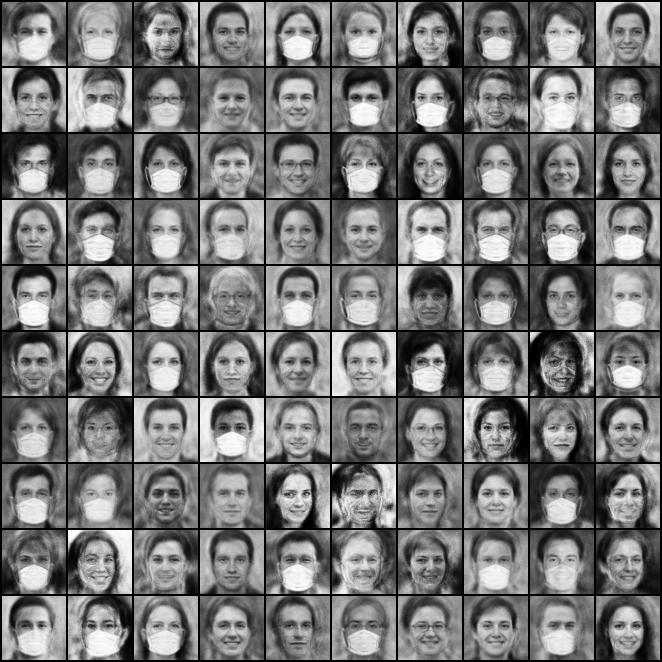

In [23]:
# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()

# 이미지 생성
generated_imgs = wganGP_generator(z)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/customGAN/WGAN-GP/without_mask.png', nrow=10, normalize=True)

files.download('./results/customGAN/WGAN-GP/without_mask.png')
Display('./results/customGAN/WGAN-GP/without_mask.png')


In [25]:
# 평가 수행 : face-without-mask
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/customGAN/WGAN-GP/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 32

Looking for images in ./results/customGAN/WGAN-GP/without_mask/*.png
Looking for images in ./results/customGAN/WGAN-GP/without_mask/*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask/*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask/*.jpg
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.w

In [26]:
# 평가 수행 : face-with-mask
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/customGAN/WGAN-GP-GPAN/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 32

Looking for images in ./results/customGAN/WGAN-GP-GPAN/with_mask/*.png
Looking for images in ./results/customGAN/WGAN-GP-GPAN/with_mask/*.jpg
Traceback (most recent call last):
  File "./pytorch-frechet-inception-distance/fid.py", line 275, in <module>
    images1 = load_images(options.path1)
  File "./pytorch-frechet-inception-distance/fid.py", line 243, in load_images
    first_image = cv2.imread(image_paths[0])
IndexError: list index out of range


In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
df = pd.DataFrame({'G': G_losses[1:], 'D': D_losses[1:]})
ax1 = sns.lineplot(data=df, x=df.index, y='G', label='G', color='royalblue', alpha=.75)
ax2 = ax1.twinx()
sns.lineplot(data=df, x=df.index, y='D', label='D', color='orange', alpha=.75, ax=ax2)
for ax in [ax1, ax2]:
#     ax.set_ylim(bottom=0.)
    ax.legend([])
ax1.figure.legend(frameon= False)
files.download('./Loss_during_WGAN-GP_Train1.png')
plt.show()


plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
df = pd.DataFrame({
    'G': np.mean(np.array(G_losses).reshape(len(G_losses) // n_epochs, -1), axis=0),
    'D': np.mean(np.array(D_losses).reshape(len(D_losses) // n_epochs, -1), axis=0)
})
ax1 = sns.lineplot(data=df, x=df.index, y='G', label='G', color='royalblue', alpha=.75)
ax2 = ax1.twinx()
sns.lineplot(data=df, x=df.index, y='D', label='D', color='orange', alpha=.75, ax=ax2)
for ax in [ax1, ax2]:
#     ax.set_ylim(bottom=0.)
    ax.legend([])
ax1.figure.legend(frameon=False)
files.download('./Loss_during_WGAN-GP_Train2.png')
plt.show()

In [28]:
# result폴더의 모든 파일을 results_customWGAN-GP.zip라는 이름으로 압축
!zip ./results_customWGAN-GP_nolabel.zip -r ./results/customGAN/WGAN-GP/*
files.download('./results_customWGAN-GP_nolabel.zip')

  adding: results/customGAN/WGAN-GP/with_mask/ (stored 0%)
  adding: results/customGAN/WGAN-GP/with_mask/932.png (deflated 2%)
  adding: results/customGAN/WGAN-GP/with_mask/410.png (deflated 2%)
  adding: results/customGAN/WGAN-GP/with_mask/873.png (deflated 0%)
  adding: results/customGAN/WGAN-GP/with_mask/449.png (deflated 0%)
  adding: results/customGAN/WGAN-GP/with_mask/652.png (deflated 2%)
  adding: results/customGAN/WGAN-GP/with_mask/667.png (deflated 1%)
  adding: results/customGAN/WGAN-GP/with_mask/980.png (deflated 1%)
  adding: results/customGAN/WGAN-GP/with_mask/533.png (deflated 1%)
  adding: results/customGAN/WGAN-GP/with_mask/609.png (deflated 0%)
  adding: results/customGAN/WGAN-GP/with_mask/638.png (deflated 1%)
  adding: results/customGAN/WGAN-GP/with_mask/106.png (deflated 1%)
  adding: results/customGAN/WGAN-GP/with_mask/588.png (deflated 2%)
  adding: results/customGAN/WGAN-GP/with_mask/950.png (deflated 1%)
  adding: results/customGAN/WGAN-GP/with_mask/669.png (de

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* PPT에 들어갈 내용
    1. 최종적으로 얻은 점수 (마스크 미착용 FID 점수 + 마스크 착용 FID 점수)
    2. 좋은 결과를 만들기 위해 어떤 전략을 사용했는지, 그 이유는 무엇인지
    3. 소스코드에서 핵심이 되는 부분 캡처 사진 및 설명
    4. 자신의 GAN에서 생성된 이미지들 캡처 사진
* 점수 판정 기준
    * <b>FID의 점수 합이 가장 작은 팀</b>이 1등입니다.
    * 마스크 미착용 FID 점수 = 171.67이고, 마스크 착용 FID 점수 = 114.97이라면?
    * 최종 점수 = 171.67 + 114.97 = 286.64
* 최종적으로 <b>팀 단위로 제출할 파일</b>은 다음과 같습니다.
    1. PPT 파일: 사용한 모델과 최종적인 FID 점수에 대한 설명을 포함하기
    2. Colab Notebook 파일: <b>[파일]</b> - <b>[다운로드]</b> - <b>[.ipynb 다운로드]</b>
    3. 최종 결과 이미지(마스크 착용 1,000개 및 마스크 미착용 1,000개)가 포함된 압축 파일
* 최종 결과 이미지는 다음과 같은 양식으로 압축 파일(.zip) 형태로 제출합니다.
    * with_mask와 without_mask 이미지들이 서로 다른 폴더로 확실히 구분되어야 합니다.
    * <b>PPT에 기록된 FID 점수와 동일한 점수</b>가 나오는 이미지여야 합니다.

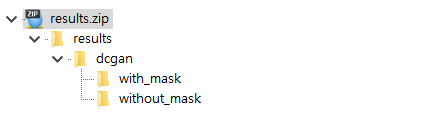

* GAN은 학습이 어려운 네트워크 중 하나입니다.
    * 학습 자체가 안 되는 문제가 발생할 수 있습니다. (처음부터 D loss: 0.5, G loss: 1.0 고정되는 문제)
    * 같은 레이블에 대하여 거의 똑같은 이미지만 생성될 수 있습니다. (mode collapse)
* (Hint) 학습이 잘 안 되는 경우 배치 사이즈, learning rate, 아키텍처를 다시 확인하고 조절합니다.
* FID 점수는 이미지 생성을 할 때마다 변경될 수 있습니다.
    * 실제로 해당 FID 점수가 나왔는지 확인할 필요가 있으므로, 생성된 이미지 파일(총 2,000장)을 꼭 함께 제출합니다.